In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
from scipy import stats
from scipy.stats import poisson
from scipy.stats import norm

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')

In [3]:
hf.keys()

<KeysViewHDF5 ['data']>

In [4]:
data = np.array(hf.get('data'))

In [5]:
hf.close()

Problem 1

The goal is to understand our data and eventually be able to build a background pdf(). Let's explore this data with some plots

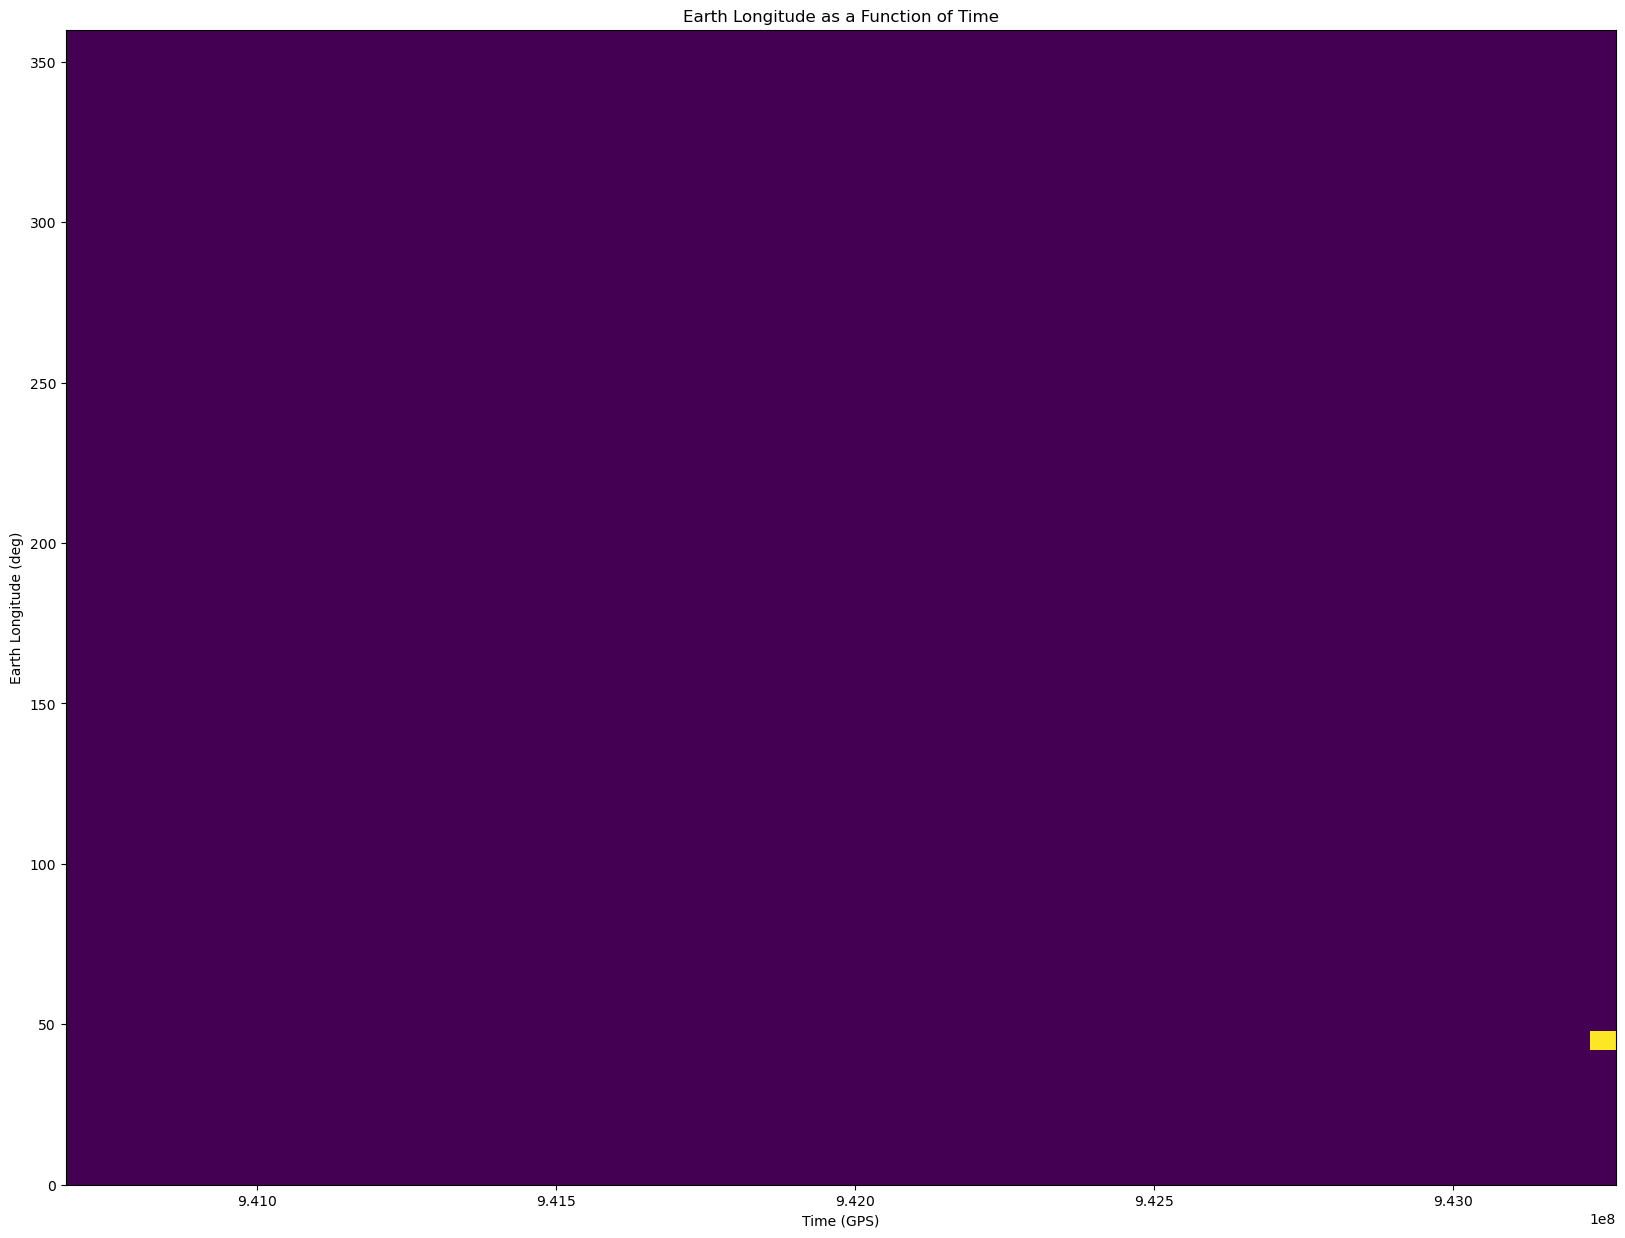

In [5]:
#Earth longitude vs time 
t = data[0]
longitude = data[2]
plt.hist2d(t,longitude,bins=60)
plt.title('Earth Longitude as a Function of Time')
plt.ylabel('Earth Longitude (deg)')
plt.xlabel('Time (GPS)')
plt.show()

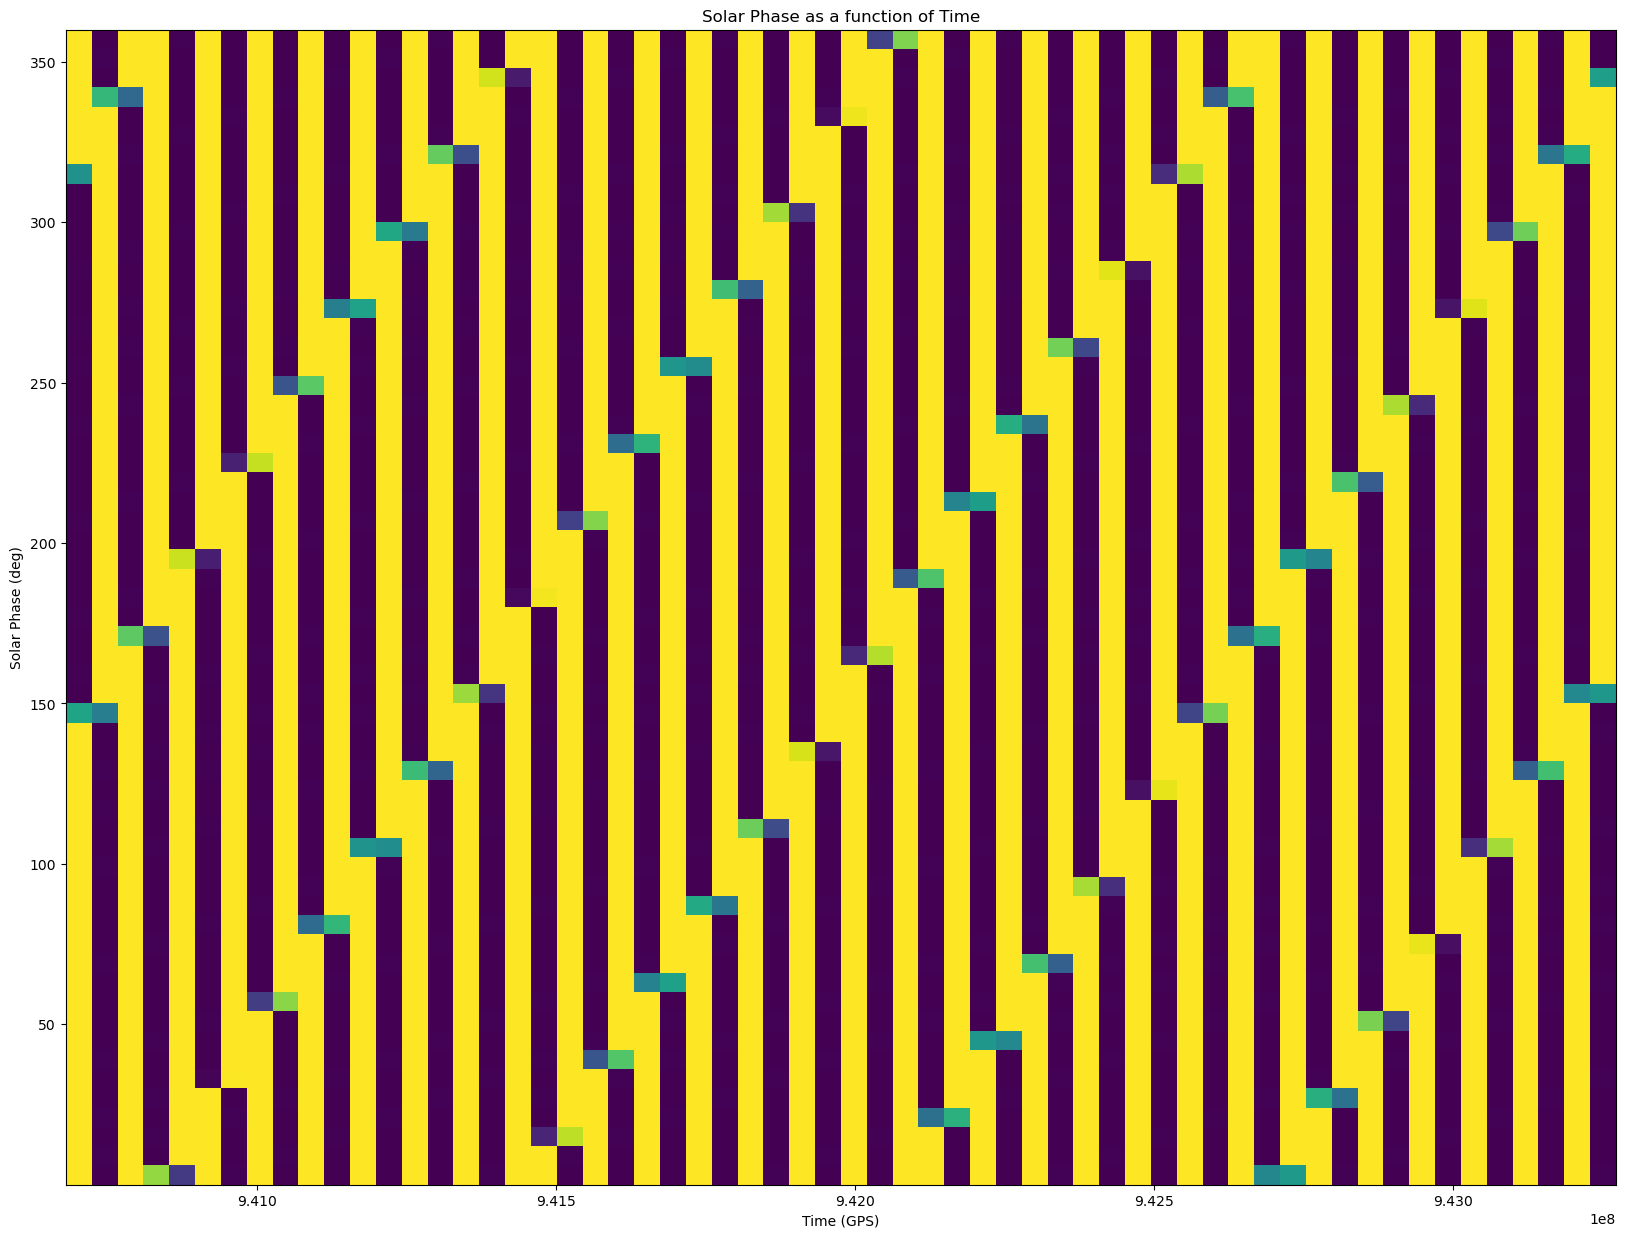

In [6]:
#solar phase vs time 
phase = data[1]
plt.hist2d(t,phase,bins=60)
plt.title('Solar Phase as a function of Time')
plt.xlabel('Time (GPS)')
plt.ylabel('Solar Phase (deg)')
plt.show()

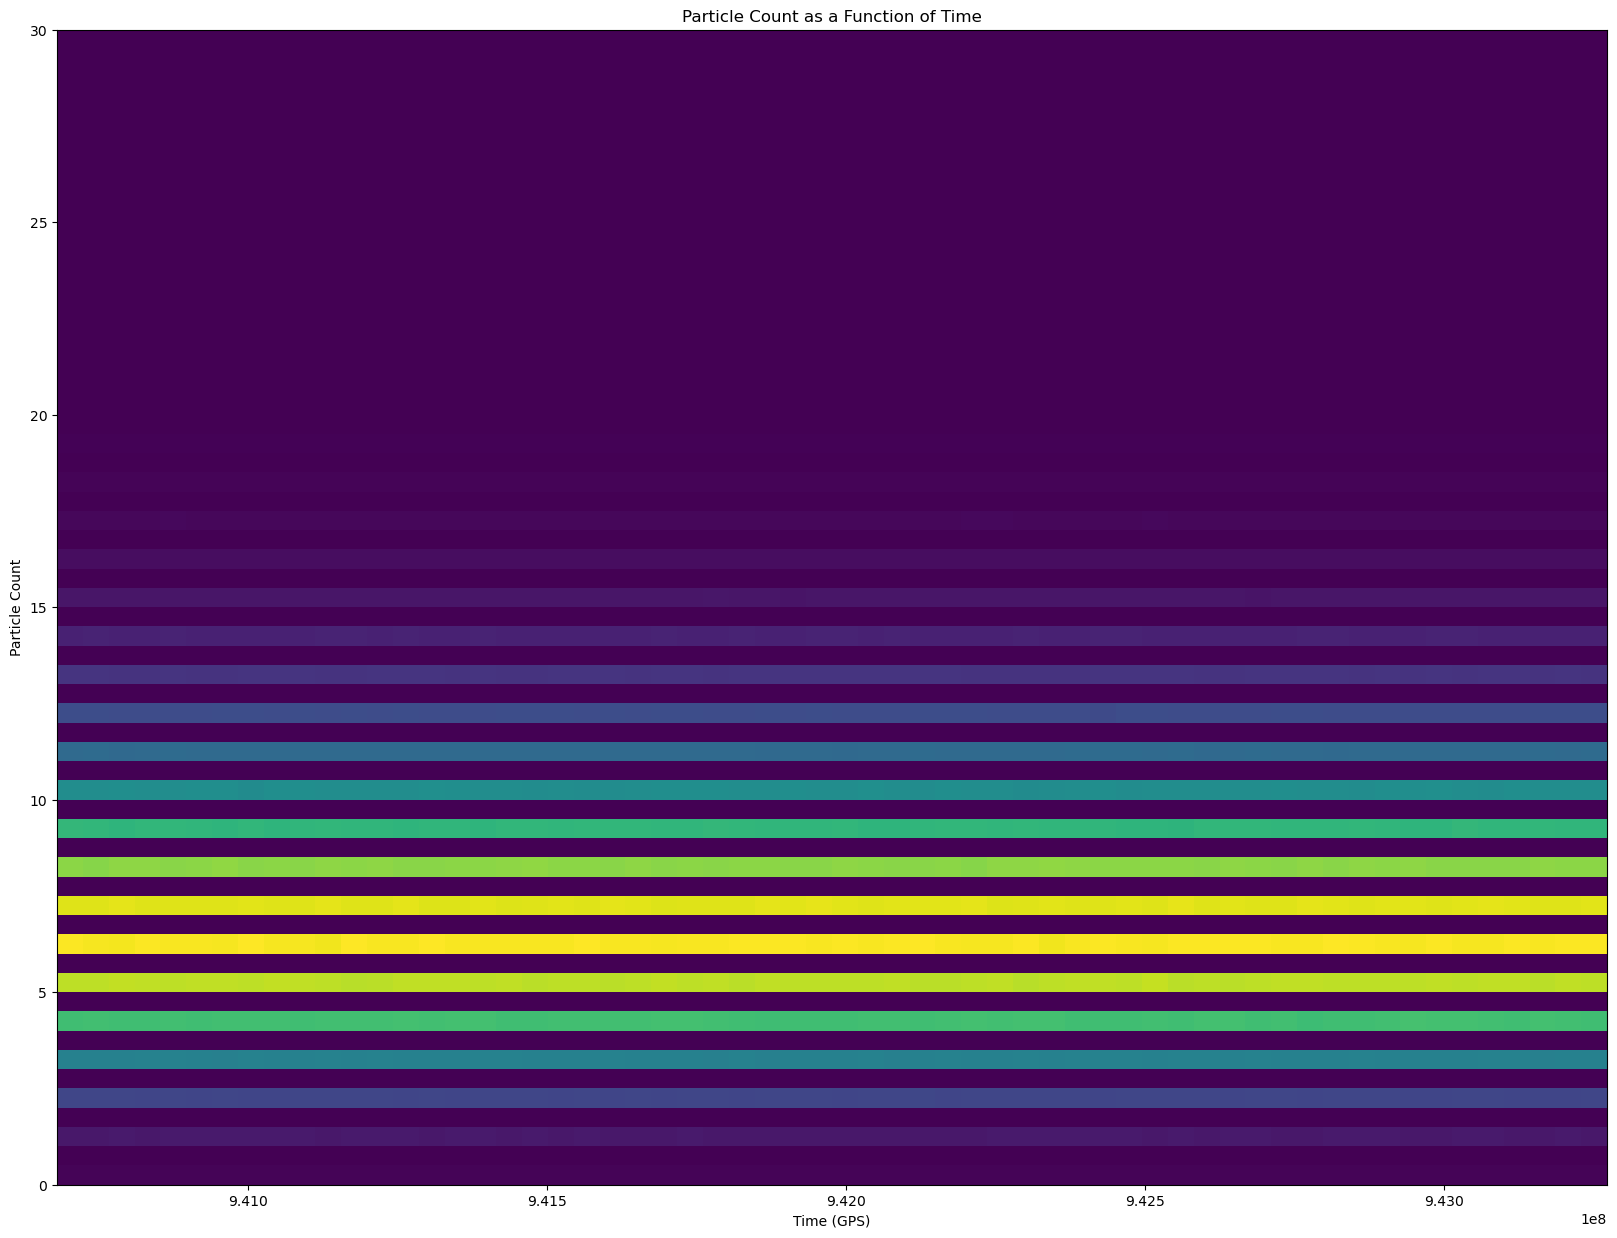

In [7]:
#Particle counts vs time
count = data[3]
plt.hist2d(t,count,bins=60)
plt.title('Particle Count as a Function of Time')
plt.ylabel('Particle Count')
plt.xlabel('Time (GPS)')
plt.show()

The reasoning behind all of these plots, specifically the ones that are as a function of time, is to explore the periodicity of the data. We need to fold the data to explore the periodicity. We know that the satellite completes an orbit every 90 minutes (5400 s). Folding the time, we can see a cyclic pattern:

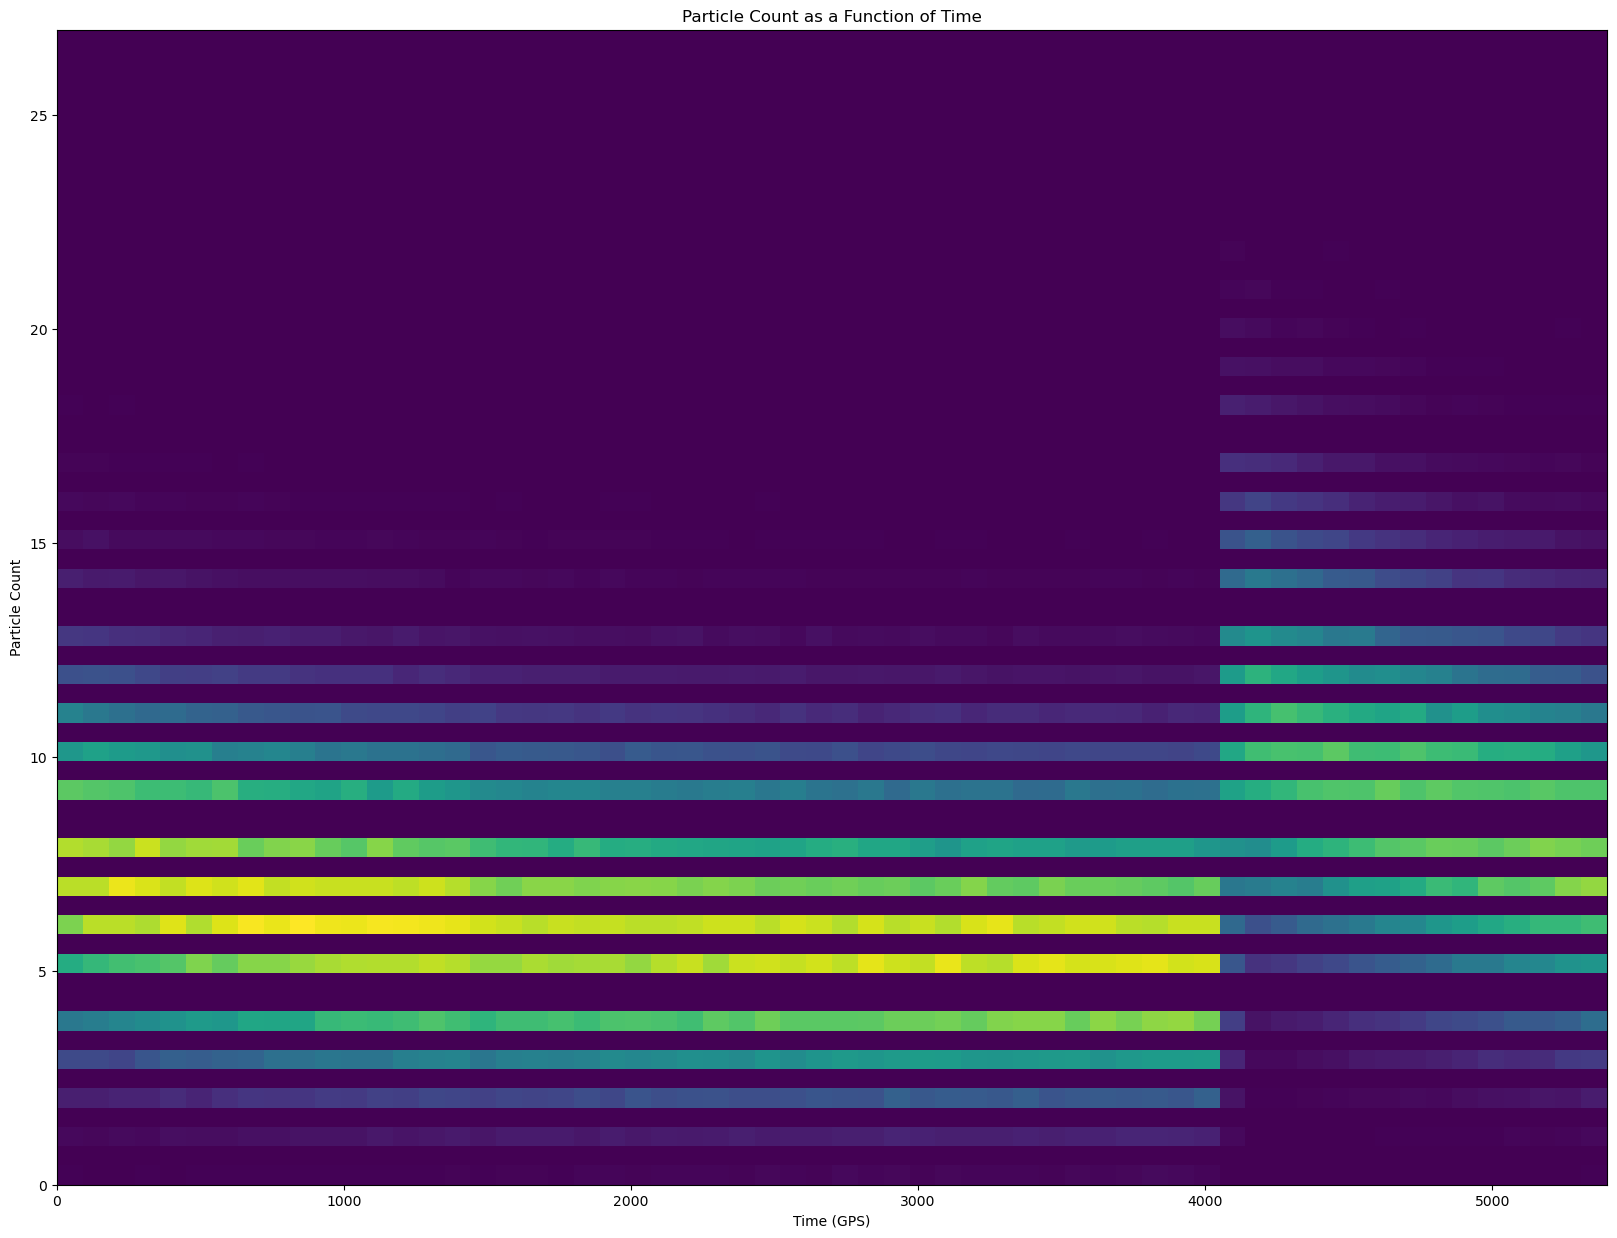

In [20]:
foldedt = np.mod(t,5400)
plt.hist2d(foldedt,count,bins=60)
plt.title('Particle Count as a Function of Time')
plt.ylabel('Particle Count')
plt.xlabel('Time (GPS)')
plt.show()

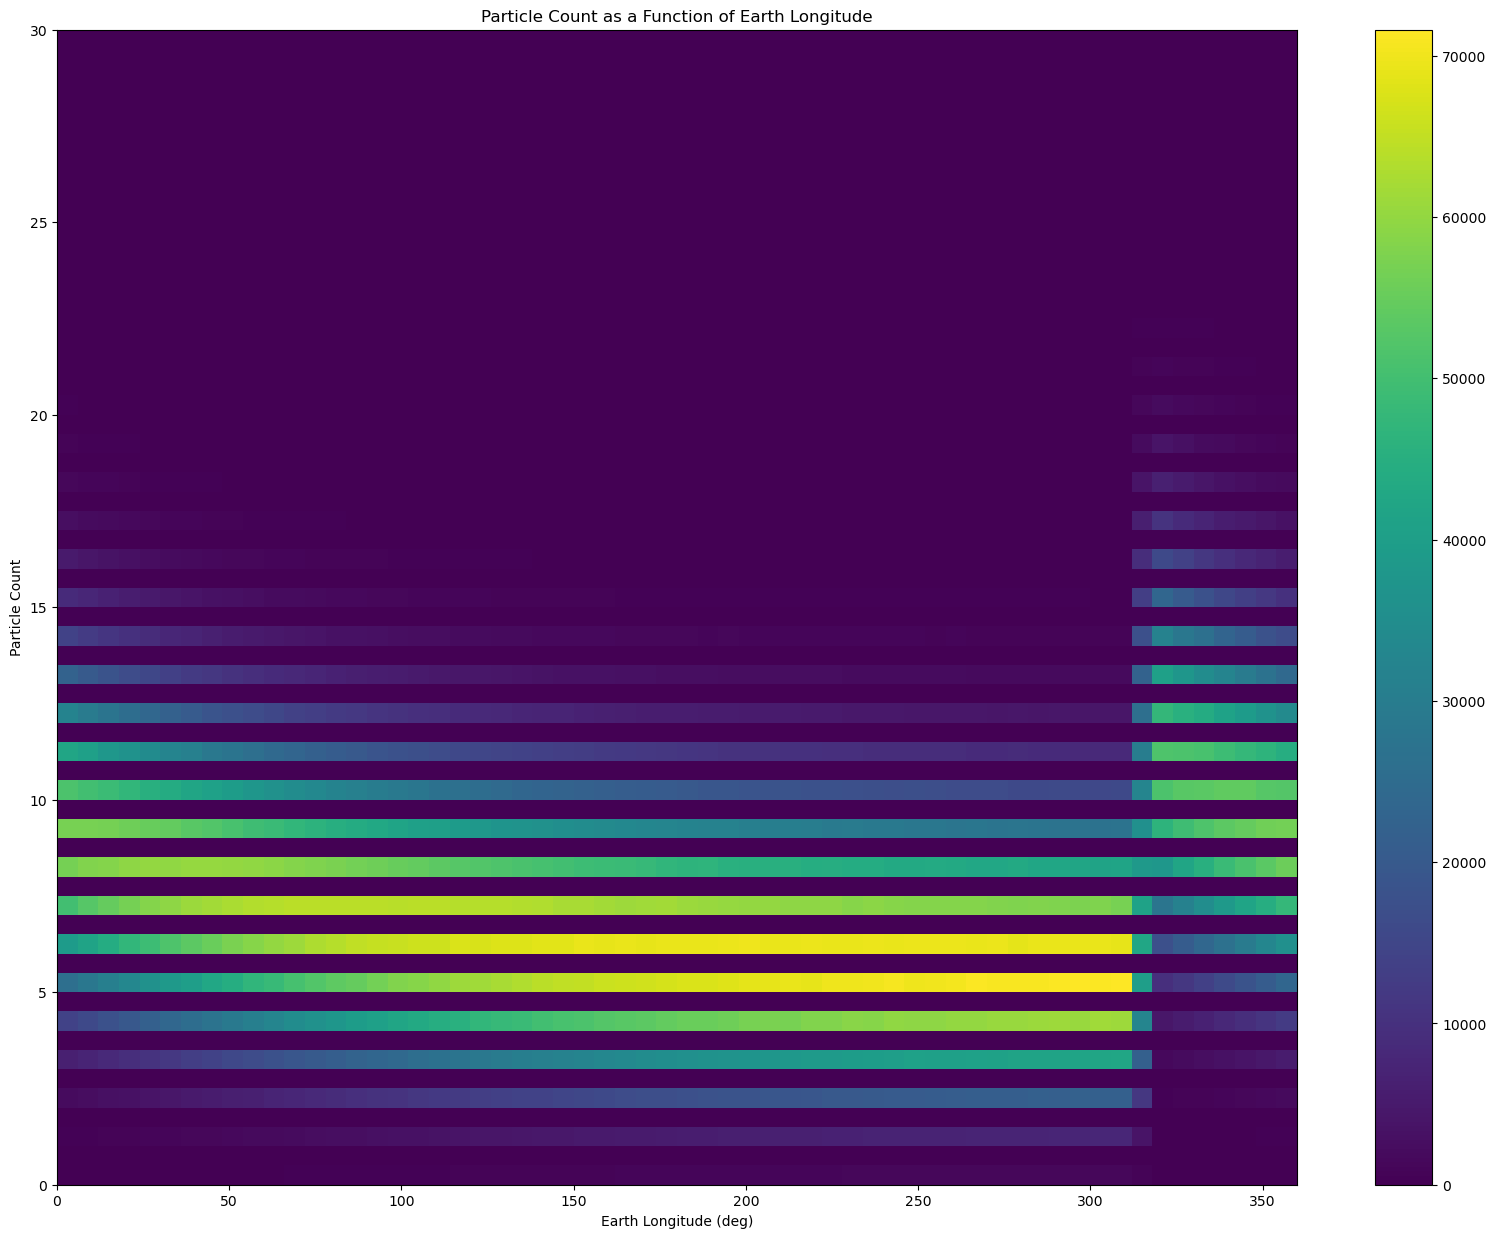

In [10]:
#Particle Count vs earth longitude
plt.hist2d(longitude,count,bins=60)
plt.title('Particle Count as a Function of Earth Longitude')
plt.ylabel('Particle Count')
plt.xlabel('Earth Longitude (deg)')
plt.colorbar()
plt.show()

As we can see from the plot above, the data set spikes at around 325 degrees. Let's explore this a little further.

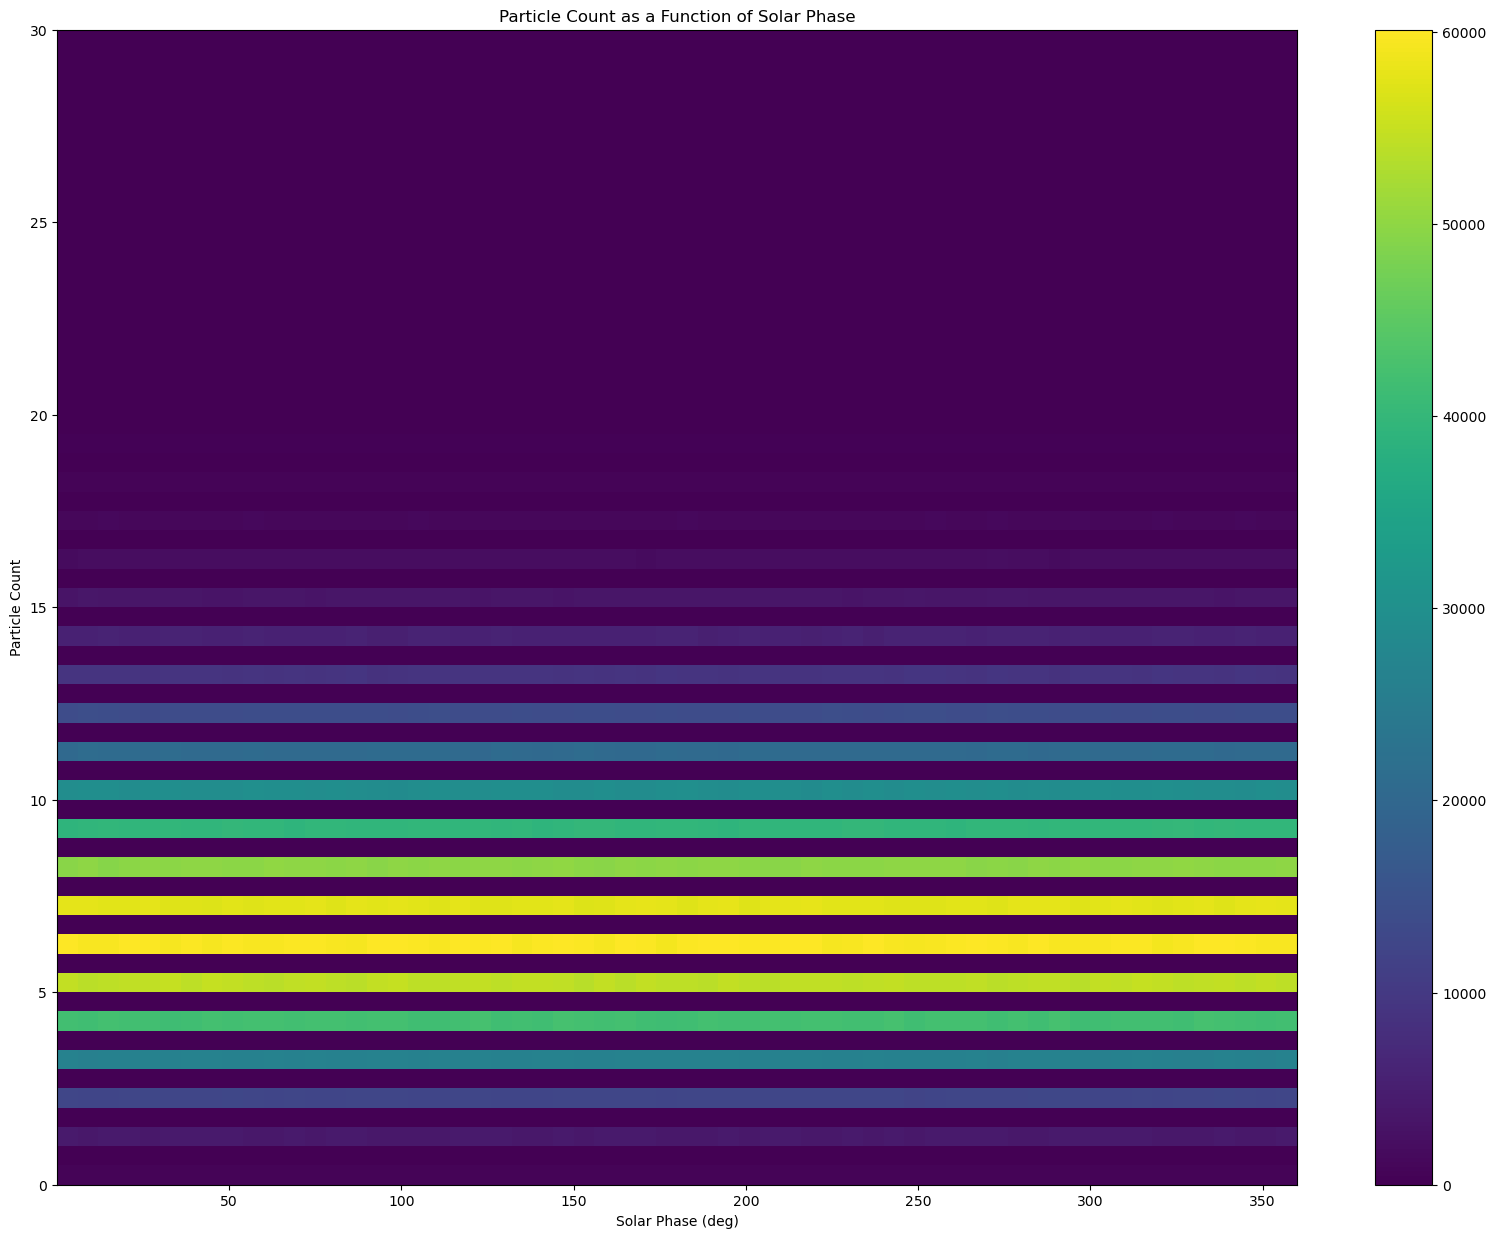

In [11]:
#Particle Count vs solar phase
plt.hist2d(phase,count,bins=60)
plt.title('Particle Count as a Function of Solar Phase')
plt.ylabel('Particle Count')
plt.xlabel('Solar Phase (deg)')
plt.colorbar()
plt.show()

This is reminiscent of the poisson distribution which makes sense because the background data is cosmic rays which is a set of discrete data. Let's find out

Text(0, 0.5, 'Frequency (log)')

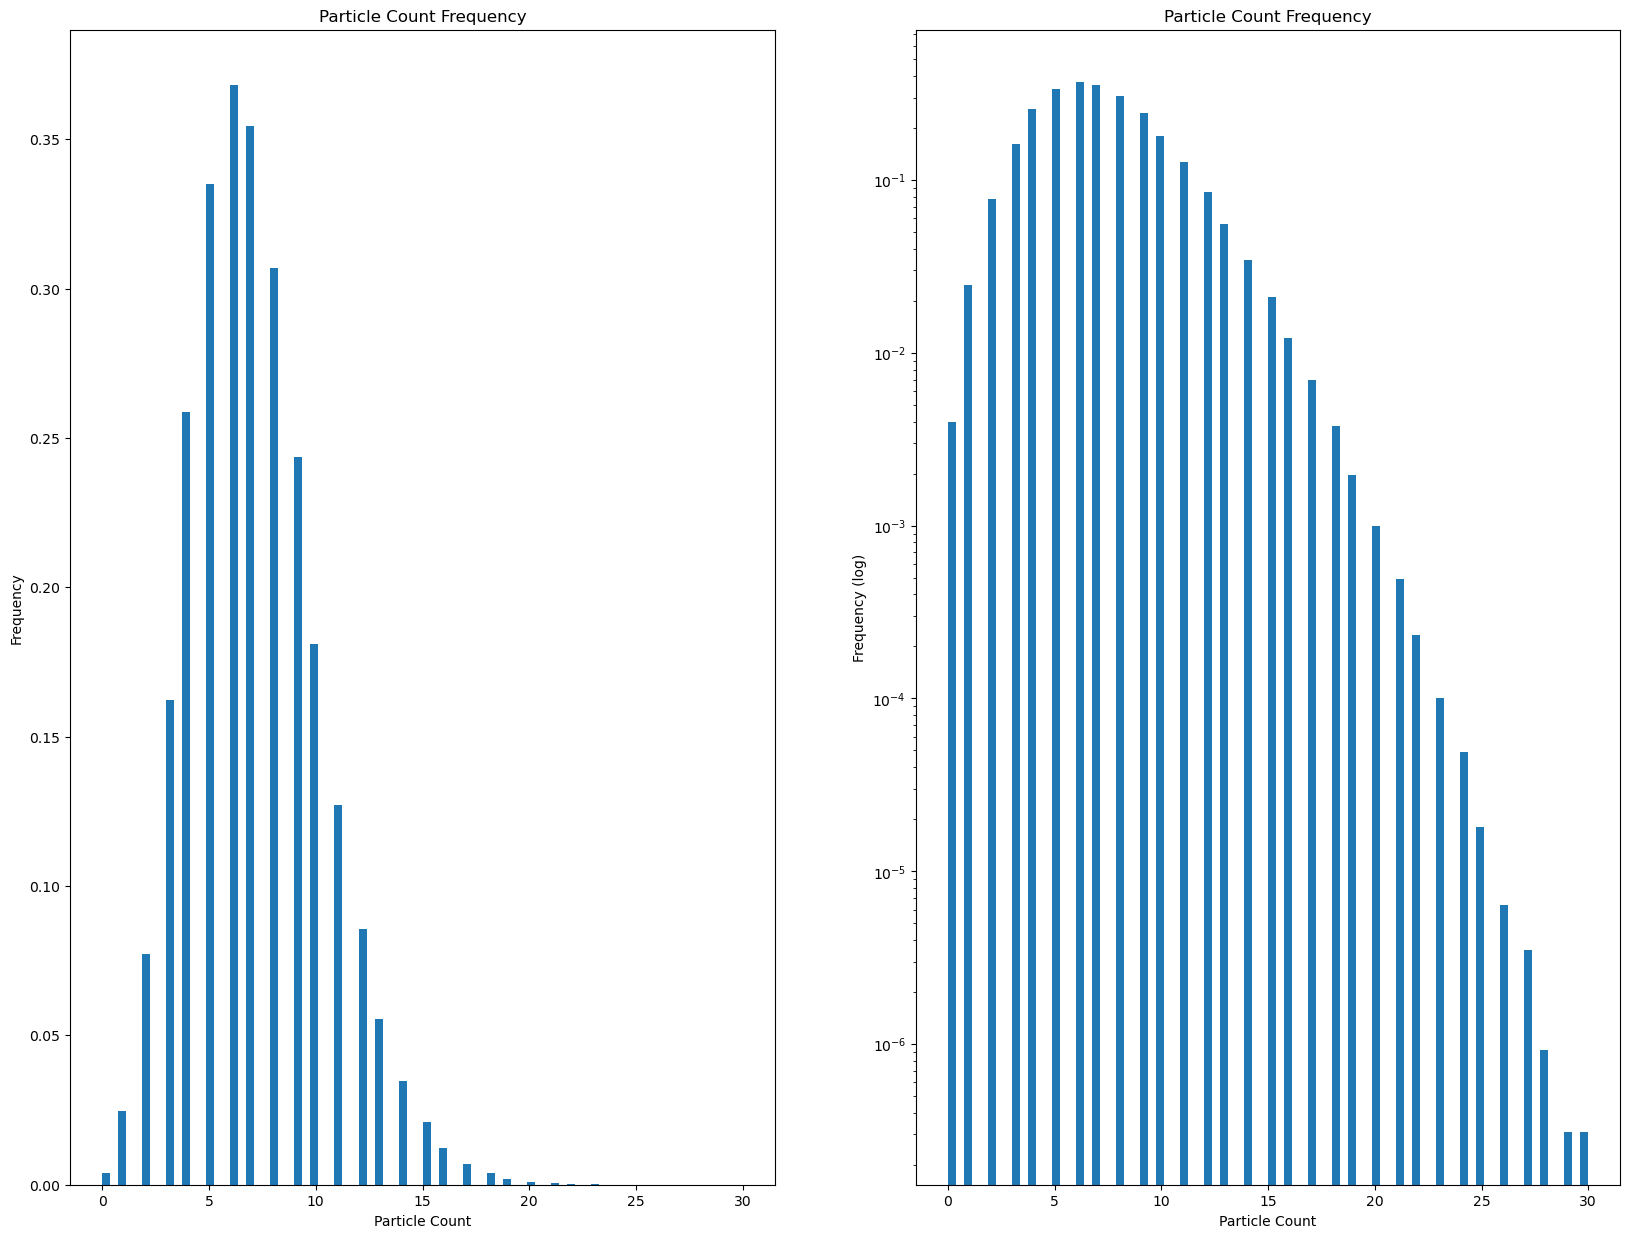

In [12]:
fig,ax = plt.subplots(1,2)
ax[0].hist(count,bins=80,density=True)
ax[0].set_title('Particle Count Frequency')
ax[0].set_xlabel('Particle Count')
ax[0].set_ylabel('Frequency')

ax[1].hist(count,bins=80,density=True)
plt.yscale('log')
ax[1].set_title('Particle Count Frequency')
ax[1].set_xlabel('Particle Count')
ax[1].set_ylabel('Probability (log)')

1. By exploring the 2D histograms of several parameters in the data, we are able to build the background distribution which we determined was a poisson distribution. 

2. The background data cannot be consistent over time because there is a periodicity as determined before. Let's look into this further:

Text(0, 0.5, 'Particle Count')

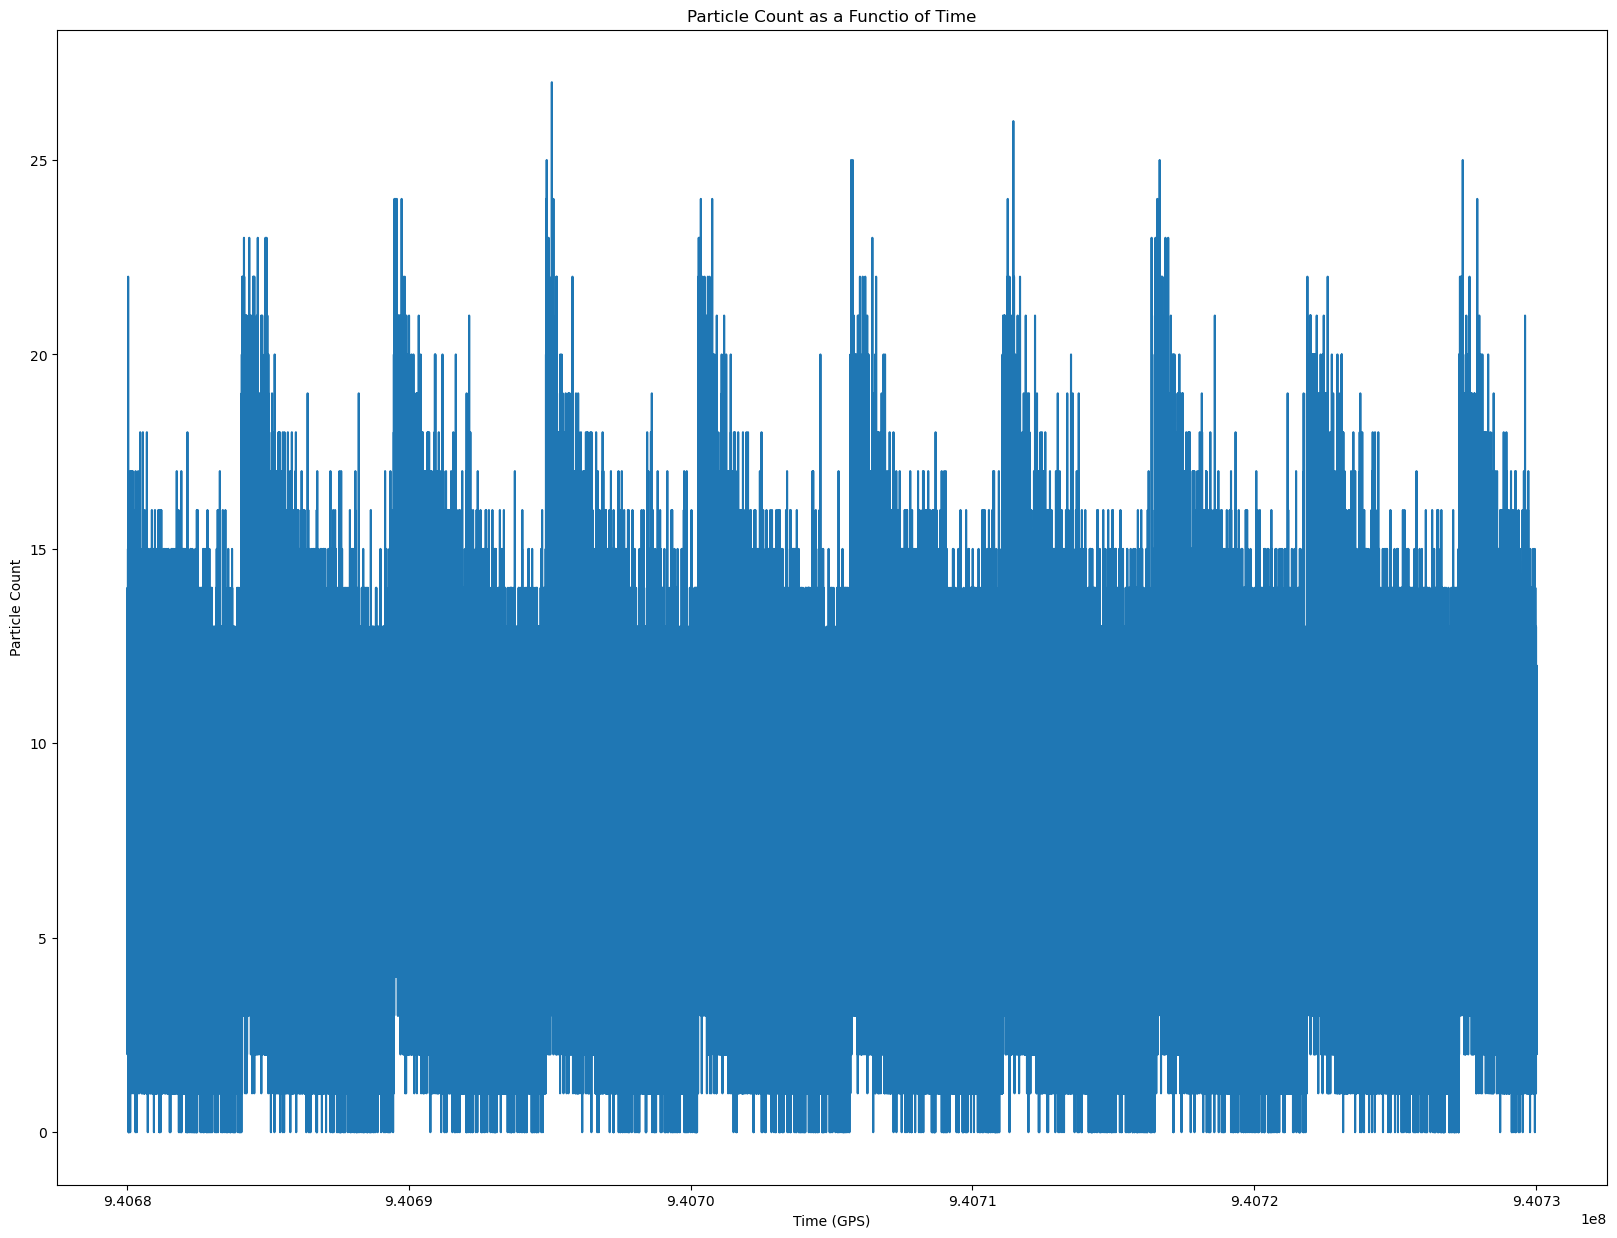

In [8]:
fig,ax = plt.subplots(1,1)
t = data[0,0:500000]
count = data[3,0:500000]
ax.plot(t,count)
ax.set_title("Particle Count as a Functio of Time")
ax.set_xlabel('Time (GPS)')
ax.set_ylabel('Particle Count')

Let's find the period by analyzing the difference in time between two peaks: 9.40695 - 9.40690 = 0.00005. This is equivalent to 90 minutes it takes the satelite to complete an orbit. 

3. We can find a model to this background data by finding a distribution to fit the background. This model will also depend on time. 

 Problem 2

In [30]:
image = h5py.File('images.h5', 'r')
image1 = np.array(image.get('image1'))
imagedata = np.array(image.get('imagestack'))  # pull data out of file
image.close()

Let's explore this data. It is assumed that the images are taken at different points in time at night so if we wanted to check for time dependence we can look for any differences across the images. let's check

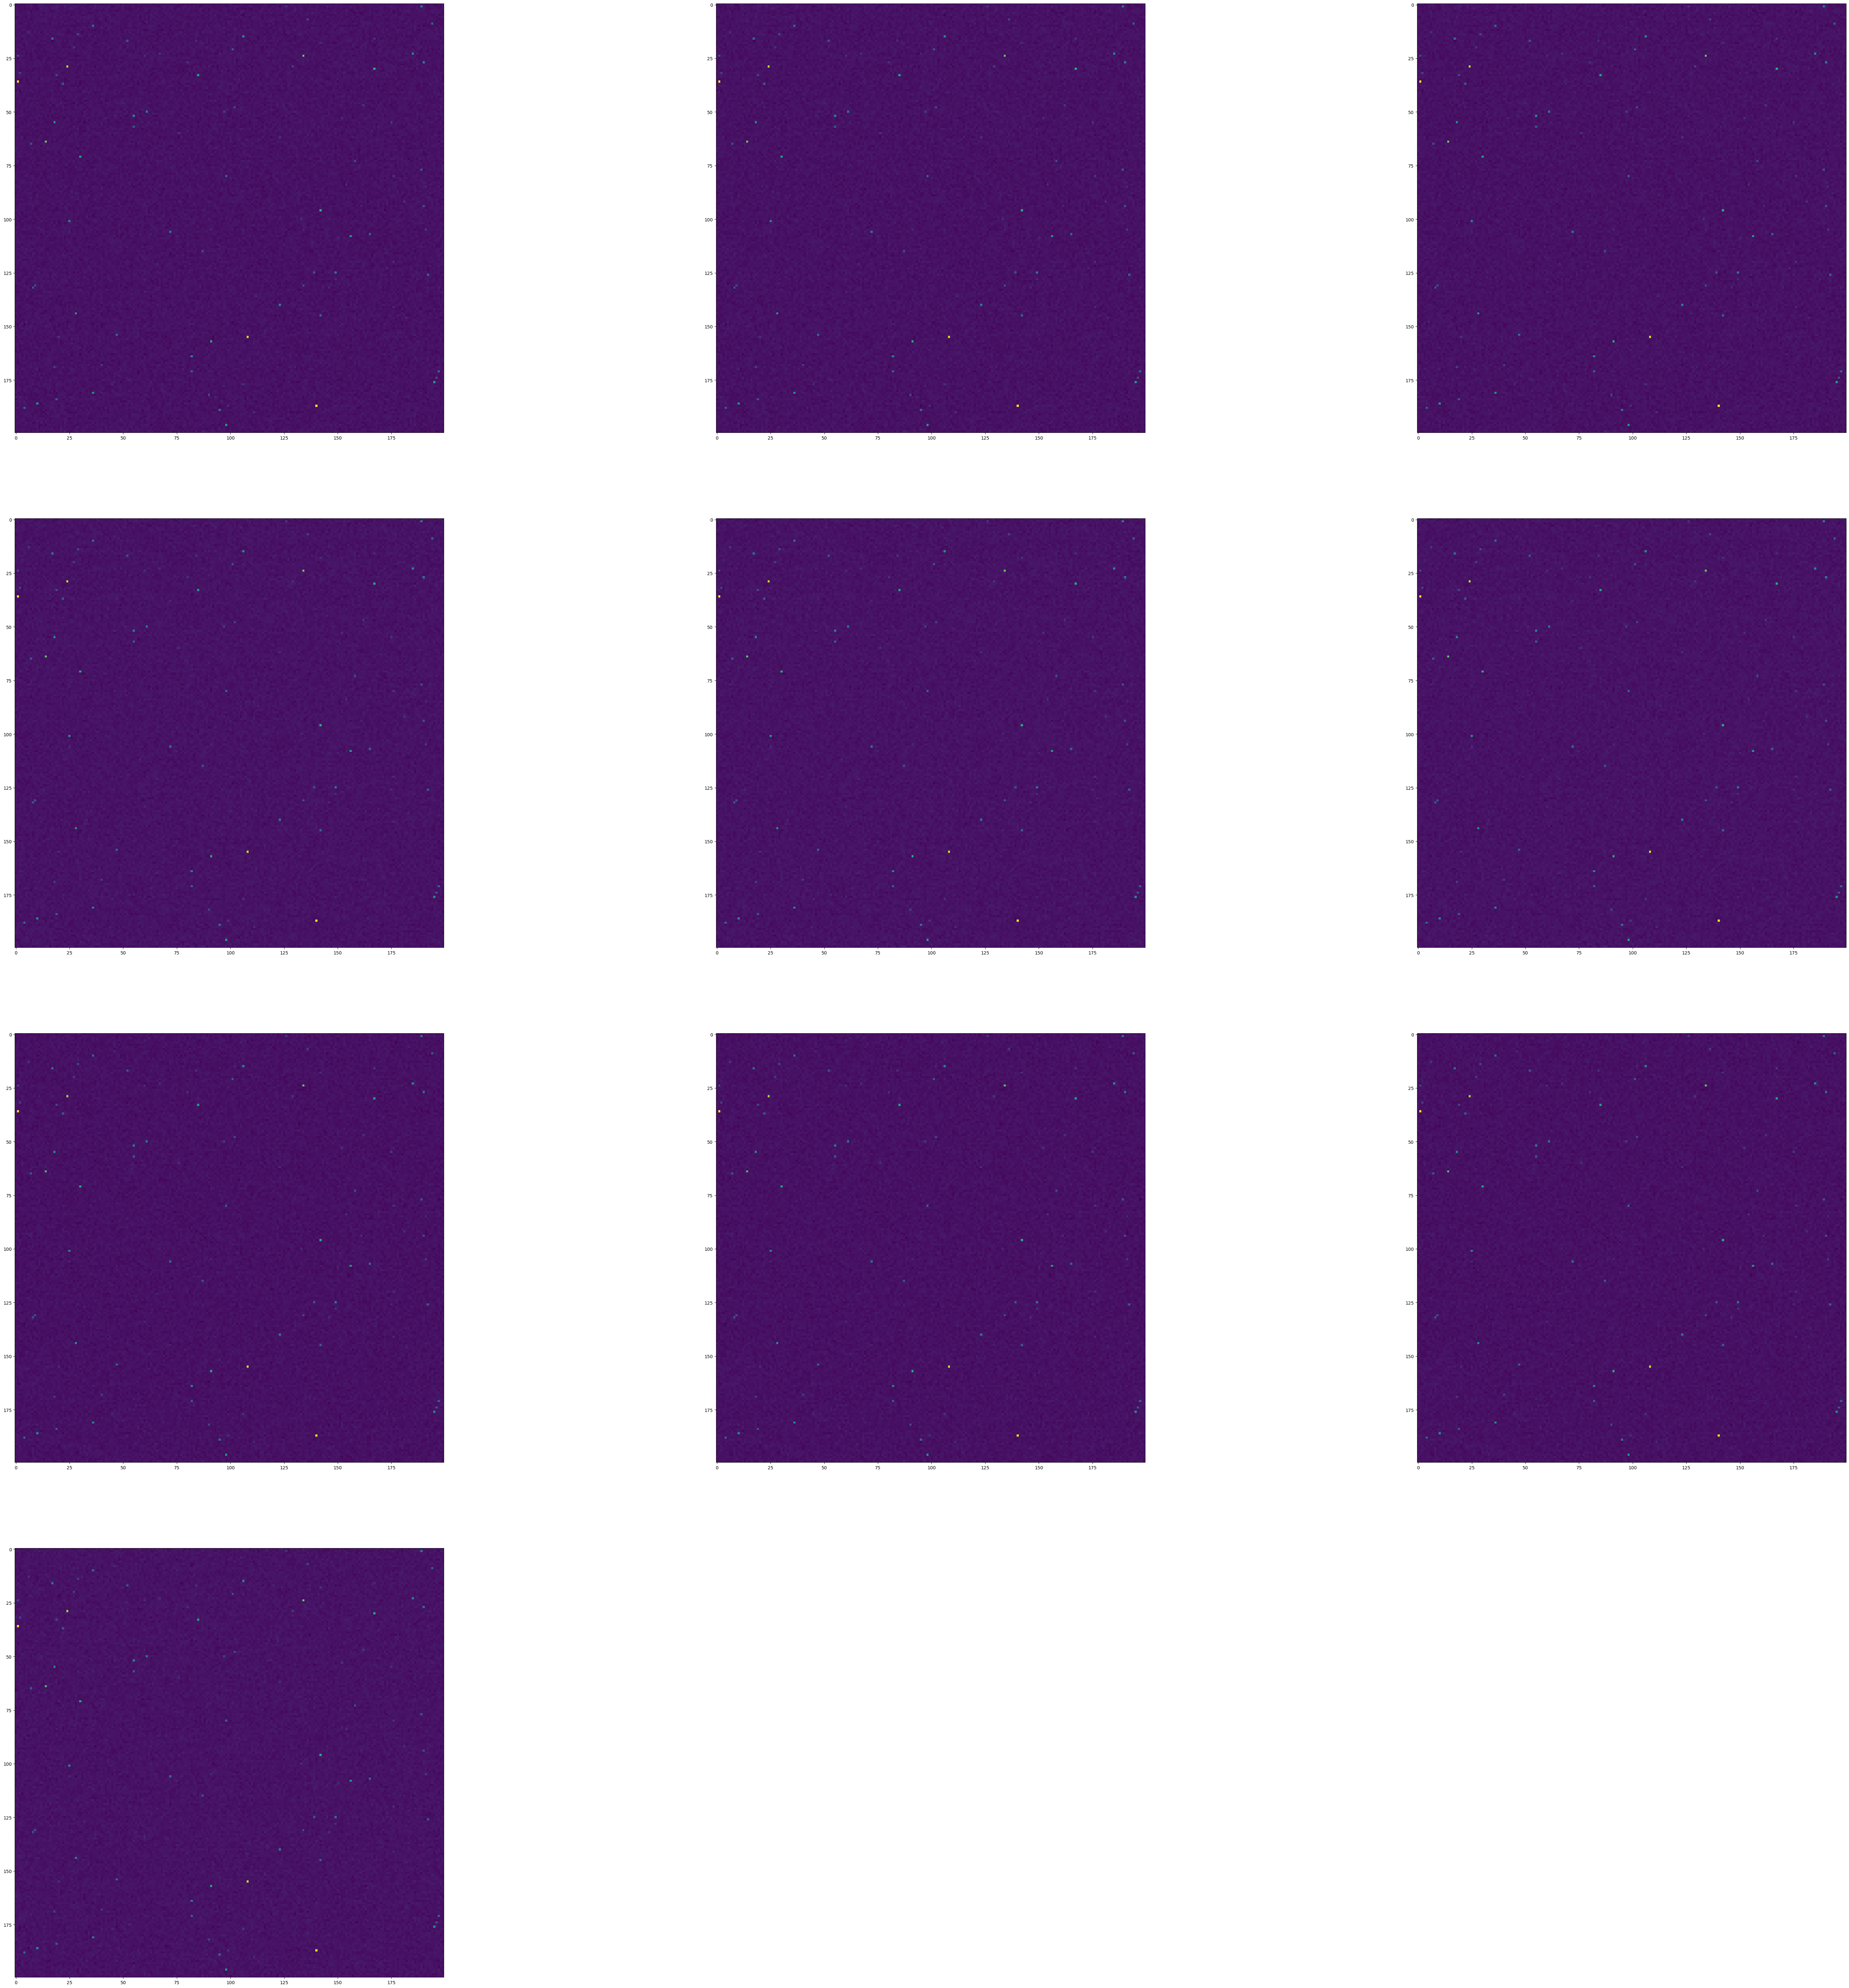

In [47]:
# 10 images 
fig,ax = plt.subplots(4,3,figsize=(80,80))
imageNum = 0
for i in range (3):
    for j in range(3):
        ax[i][j].imshow(imagedata[:,:,imageNum])
    imageNum = imageNum + 1
ax[3][0].imshow(imagedata[:,:,9])
fig.delaxes(ax[3][1])
fig.delaxes(ax[3][2])

We can see that the images do not change which means that the background is not time dependent. Also, these plots also tell us that the background is spatially consistent. Across all of the images, however, there has to be signal contamination. The images all show the night sky with stars at different brightness, so the signal that we are looking for must be a feature that is not shared across all images, i.e. a transient because it only lasts a short period of time. So we can build our pdf based on the fact that the background is the normal night sky (shared by all images) and the signal is the transient that pops up in one of these images. 

Let's find the background distribution first.